# Over-Representation Analysis

Notebook for performing an over-representation analysis on the top and bottom strains, in terms of redness and normalized redness.

2020-02-26

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


## 1. Load data

We will use:
* 4 lists (generated manually):
  * Top 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Top 500 genes in terms of normalized redness, with size $\geq$ 260.
  * Bottom 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Bottom 500 genes in terms of normalized redness, with size $\geq$ 180 and count > 1.
* The lookup table connecting positions in the 384-well plate to gene ids, as it has all GO-terms associated to each gene ID.

In [2]:
import pandas as pd

data = pd.read_csv(join(INTERMEDIATE,"top_and_bottom_500.csv"))
print(data)

    top_redness top_norm_redness bottom_redness bottom_norm_redness
0          CSE2             GAS5          IBA57                OPY1
1          MLC2             YOR1           OPY1                RIM8
2          YOR1          YJL175W        YCR090C               IBA57
3          NTA1             SKY1           HTD2                BUD8
4       YOL153C          YIL096C           DIA3               RPL9A
..          ...              ...            ...                 ...
495        PTK1             TRP1          SPO74                RTC2
496     YBR287W          YPR071W        YDL211C                IPK1
497        PLB2             BPT1           YCH1             YMR160W
498        TRP1             NEJ1           YSP2                STP2
499     YKR070W             REX3        YIL012W             YGL152C

[500 rows x 4 columns]


In [3]:
gene_ids = pd.read_csv(join(RAW_EXTERNAL,"geneIDs.txt"), sep="\t")
gene_ids = gene_ids[gene_ids["Gene"] != "Blank"]  # filter out blank data
gene_ids = gene_ids.drop(columns=["Plate #", "Row", "Column", "96-position"])  # remove unused columns
gene_ids.index = range(0,len(gene_ids.index))  # re-index for consistency later on
print(gene_ids)

            ORF       Gene                                         Decription  \
0       YLL040C      VPS13  Protein of unknown function; heterooligomeric ...   
1       YAL068C       PAU8  Protein of unknown function, member of the ser...   
2       YAL067C       SEO1  Putative permease, member of the allantoate tr...   
3       YLL041C       SDH2  Iron-sulfur protein subunit of succinate dehyd...   
4       YAL066W    YAL066W  Dubious open reading frame unlikely to encode ...   
...         ...        ...                                                ...   
4842    YER122C       GLO3  ADP-ribosylation factor GTPase activating prot...   
4843    YJL075C      APQ13  Dubious open reading frame, unlikely to encode...   
4844    YBR035C       PDX3  Pyridoxine (pyridoxamine) phosphate oxidase, h...   
4845    YPR072W       NOT5  Subunit of the CCR4-NOT complex, which is a gl...   
4846  YOR008C-A  YOR008C-A  Putative protein of unknown function, includes...   

                           

## 2. GO terms

We will first collect all GO terms in a single list, to be able to iterate through later.

In [4]:
GOterms = []
for (idx, row) in gene_ids.iterrows():
    row["GO Biological Process"] = row["GO Biological Process"].split(", ")
    GOterms.extend(row["GO Biological Process"])
GOterms = list(set(GOterms))
GOterms.sort()
print(GOterms)
GOterms.remove('-')

['-', 'DNA metabolic process', 'RNA metabolic process', 'biological_process', 'cell budding', 'cell cycle', 'cellular amino acid and derivative metabolic process', 'cellular aromatic compound metabolic process', 'cellular carbohydrate metabolic process', 'cellular component morphogenesis', 'cellular homeostasis', 'cellular lipid metabolic process', 'cellular membrane organization', 'cellular protein catabolic process', 'cellular respiration', 'chromosome organization', 'chromosome segregation', 'cofactor metabolic process', 'conjugation', 'cytokinesis', 'cytoskeleton organization', 'fungal-type cell wall organization', 'generation of precursor metabolites and energy', 'heterocycle metabolic process', 'meiosis', 'mitochondrion organization', 'nucleus organization', 'other', 'peroxisome organization', 'protein complex biogenesis', 'protein folding', 'protein modification process', 'pseudohyphal growth', 'response to chemical stimulus', 'response to stress', 'ribosome biogenesis', 'signal

## 3. Over-Representation Analysis

We need a function for the over-representation analysis. For each GO term the Fisher matrix is constructed as:

|   | Selected in group | Not selected |
|:-:|:-----------------:|:------------:|
| With GO term | F[0][0] | F[0][1] |
| Without GO term | F[1][0] | F[1][1] |

And then the alternative hypothesis is that there is a higher percentage of genes in the selected group with the GO term Vs without the GO term.

In [5]:
from fisher import pvalue

# over-representation function:
def over_rep(data, group_name, gene_ids, GOterms):
    pvalues = pd.DataFrame()
    group = list(data[group_name])
    for GOterm in GOterms:
        F = [[0, 0], [0, 0]]
        for (idx, row) in gene_ids.iterrows():
            i = 0 if GOterm in row["GO Biological Process"] else 1
            j = 0 if row["Gene"] in group else 1
            F[i][j] += 1
        pval = pvalue(F[0][0], F[0][1], F[1][0], F[1][1]).right_tail
        new_row = pd.DataFrame(data={"genes.selected":F[0][0], "genes.total":F[0][0] + F[0][1], "p.value": pval}, index=[GOterm])
        pvalues = pvalues.append(new_row)
    print(pvalues[pvalues["p.value"] < 0.05])
    return pvalues

Now we can call the function for all 4 groups:

In [6]:
p_values_top_redness = over_rep(data, "top_redness", gene_ids, GOterms)

Empty DataFrame
Columns: [genes.selected, genes.total, p.value]
Index: []


In [7]:
p_values_top_norm_redness = over_rep(data, "top_norm_redness", gene_ids, GOterms)

                    genes.selected  genes.total   p.value
biological_process             173         1405  0.004948


In [8]:
p_values_bottom_redness = over_rep(data, "bottom_redness", gene_ids, GOterms)

                              genes.selected  genes.total   p.value
protein modification process              56          410  0.026396


In [9]:
p_values_bottom_norm_redness = over_rep(data, "bottom_norm_redness", gene_ids, GOterms)

                           genes.selected  genes.total   p.value
vitamin metabolic process               9           46  0.049671


Results don't look very promising... most likely because there are not many GO terms included in the original file.

## 4. Using GOATOOLS

Let's try using more GO terms, via GOATOOLS. For that, we first need Entrez IDs for all genes both from the total list of _S. cerevisiae_ genes and from the 4 selected groups. We can get them using the `mygene` package ([Wu et al. 2014](https://www.biorxiv.org/content/10.1101/009332v1)), querying the original ORFs:

In [10]:
import mygene
mg = mygene.MyGeneInfo()
geneORFs = list(gene_ids["ORF"])
entrezIDs = mg.querymany(geneORFs, scopes='locus_tag', fields='entrezgene', species=559292)  # S. cerevisiae S288C
entrezIDs[:10]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4847...done.
Finished.
45 input query terms found dup hits:
	[('YML086C', 2), ('YMR169C', 2), ('YMR174C', 2), ('YMR175W', 2), ('YML035C', 2), ('YMR191W', 2), ('Y
411 input query terms found no hit:
	['YAL066W', 'YLL047W', 'YLR123C', 'YLR124W', 'YML089C', 'YAL045C', 'YAL043C-a', 'YML084W', 'YMR151W'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'YLL040C',
  '_id': '850619',
  '_score': 13.253784,
  'entrezgene': '850619'},
 {'query': 'YAL068C',
  '_id': '851229',
  '_score': 13.235436,
  'entrezgene': '851229'},
 {'query': 'YAL067C',
  '_id': '851230',
  '_score': 13.2391815,
  'entrezgene': '851230'},
 {'query': 'YLL041C',
  '_id': '850685',
  '_score': 13.242646,
  'entrezgene': '850685'},
 {'query': 'YAL066W', 'notfound': True},
 {'query': 'YLL042C',
  '_id': '850684',
  '_score': 13.239901,
  'entrezgene': '850684'},
 {'query': 'YAL065C',
  '_id': '851232',
  '_score': 13.75529,
  'entrezgene': '851232'},
 {'query': 'YLL043W',
  '_id': '850683',
  '_score': 13.247383,
  'entrezgene': '850683'},
 {'query': 'YAL062W',
  '_id': '851237',
  '_score': 13.246465,
  'entrezgene': '851237'},
 {'query': 'YLL045C',
  '_id': '850682',
  '_score': 13.256932,
  'entrezgene': '850682'}]

Note that several entries are either duplicated or don't match to anything. Also, `entrezIDs` is in dictionary format, but we need it as a list of just `entrezgene` ids. So we will create a list with just that (that we will call `population`) and translate all genes in the selected groups:

In [11]:
population = []
gene_ids["entrez"] = ""
for (idx, row) in gene_ids.iterrows():
    gene = entrezIDs[idx]
    if "entrezgene" in gene:
        entrezID = int(gene["entrezgene"])  # convert to integer (needed for GOATOOLS)
        gene_ids["entrez"][idx] = entrezID  # add to datframe for easier access later
        population.append(entrezID)  # add to population
        data = data.replace(to_replace=row["Gene"], value=entrezID)  # replace in all selected groups
        
print(len(population))
data

4436


,top_redness,top_norm_redness,bottom_redness,bottom_norm_redness
0,855744,854127,853586,852426
1,856318,853198,852426,852837
2,853198,YJL175W,850452,853586
3,853525,855256,856464,851067
4,854012,854711,851537,852730
...,...,...,...,...
495,853635,851570,852705,852444
496,852590,856184,851315,851910
497,855018,850645,853117,855195
498,851570,850970,851926,856397


Note that not all genes are added to the selected genes, due to missing IDs, but the coverage is good enough (above 90% in all cases):

In [12]:
for col in data:
    mapped_genes = sum(map(lambda x : type(x) is int, list(data[col])))
    print(col + ": " + str(mapped_genes))

top_redness: 462
top_norm_redness: 458
bottom_redness: 461
bottom_norm_redness: 458


 So let's proceed. We now need a list of all ontologies, and a list of all associations gene/ontology. The package GOATOOLS ([Klopfenstein et al. 2019](https://doi.org/10.1038/s41598-018-28948-z)) provides that, together with improved enrichment tools (corrected p-values, additional tests, etc), so we will from here forward use that.

In [13]:
# Get ontologies (from http://geneontology.org/ontology/go-basic.obo)
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
obo_fname = download_go_basic_obo()  # Download data
obodag = GODag(obo_fname)  # Load data

# Get associations genes <-> ontologies (from ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz)
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
gene2go_fname = download_ncbi_associations()  # Download data
objanno = Gene2GoReader(gene2go_fname, taxids=[559292])  # Read data (only for Saccharomyces cerevisiae S288C)
ns2assoc = objanno.get_ns2assc()

#Remove downloaded data:
os.remove(obo_fname)
os.remove(gene2go_fname)

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz
HMS:0:00:03.845529  94,086 annotations,  6,349 genes,  6,156 GOs, 1 taxids READ: gene2go 


Now we create an over-representation object, with all genes, ontologies, associations and settings included in it. This object will be used for every single analysis to perform later on:

In [14]:
# Over-representation object:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goeaobj = GOEnrichmentStudyNS(
    population,  # Population (all mapped yeast genes in Entrez format)
    ns2assoc,  # geneid/GO associations
    obodag,  # Ontologies
    propagate_counts = False,  # ???
    alpha = 0.05,  # default significance cut-off
    methods = ['fdr_bh'])  # default multipletest correction method


Load BP Gene Ontology Analysis ...
 88%  3,887 of  4,436 population items found in association

Load CC Gene Ontology Analysis ...
 93%  4,141 of  4,436 population items found in association

Load MF Gene Ontology Analysis ...
 75%  3,338 of  4,436 population items found in association


Using this object, we can repeat the analysis from before for all 4 groups:

In [15]:
def goea(data, group_name, **kwargs):
    goea_results_all = goeaobj.run_study(list(data[group_name]), **kwargs)
    goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    goea_results_sig.sort(key=lambda x: (x.NS, x.GO))
    goeaobj.wr_tsv(join(FINAL, "p_values_" + group_name + ".tsv"), goea_results_sig)

goea(data, "top_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    405 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     902 GO terms are associated with    405 of    499 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 91%    418 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     238 GO terms are associated with    418 of    499 study items
  METHOD

In [16]:
goea(data, "top_norm_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 84%    387 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     876 GO terms are associated with    387 of    500 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 92%    423 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     224 GO terms are associated with    423 of    500 study items
  METHOD

In [17]:
goea(data, "bottom_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    406 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     872 GO terms are associated with    406 of    500 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 94%    435 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     281 GO terms are associated with    435 of    500 study items
  METHOD

In [18]:
goea(data, "bottom_norm_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    404 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     861 GO terms are associated with    404 of    499 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 93%    426 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     282 GO terms are associated with    426 of    499 study items
  METHOD

As observed, no ontology shows to be significant when looking at the corrected p-values. Some ontologies do show significance if we consider only the uncorrected p-values, but then false positives are to be expected. We should probably play with the number of genes inside of each group, as maybe 500 was too many...

## 5. Changing the group size

Let's start by lowering the group to 100 genes:

In [19]:
goea(data.head(100), "top_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 90%     85 of     94 study items found in association
 94%     94 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     289 GO terms are associated with     85 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 91%     86 of     94 study items found in association
 94%     94 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      90 GO terms are associated with     86 of    100 study items
  METHOD

In [20]:
goea(data.head(100), "top_norm_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     298 GO terms are associated with     83 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      93 GO terms are associated with     83 of    100 study items
  METHOD

In [21]:
goea(data.head(100), "bottom_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 85%     77 of     91 study items found in association
 91%     91 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     258 GO terms are associated with     77 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 96%     87 of     91 study items found in association
 91%     91 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     107 GO terms are associated with     87 of    100 study items
  METHOD

In [22]:
goea(data.head(100), "bottom_norm_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 84%     77 of     92 study items found in association
 92%     92 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     236 GO terms are associated with     77 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 93%     86 of     92 study items found in association
 92%     92 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     111 GO terms are associated with     86 of    100 study items
  METHOD

Still nothing significant, although the number of uncorrected p-values below 0.05 increases for all conditions. We will vary the group size from 10 to 500 in increments of 10 to find something significant (also removing the output to keep the notebook reasonably short):

In [23]:
# Function that returns the number of significant p-values according to the fdr_bh test (without printing anything):
def goea_return_sig(data, group_name, test):
    goea_results_all = goeaobj.run_study(list(data[group_name]), log=None, quiet=True)
    if test == "fdr_bh":
        goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    elif test == "uncorrected":
        goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    return goea_results_sig

# Call the function in a loop that goes through all group sizes (in multiples of 10) and records the number of significant GO terms:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "fdr_bh"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "fdr_bh"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "fdr_bh"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "fdr_bh"))
    nsig.append([n, nt, ntn, nb, nbn])

nsig

[[10, 0, 0, 0, 0],
 [20, 0, 0, 0, 0],
 [30, 0, 0, 0, 0],
 [40, 0, 0, 0, 0],
 [50, 0, 0, 0, 0],
 [60, 0, 0, 0, 0],
 [70, 0, 0, 0, 0],
 [80, 0, 0, 0, 0],
 [90, 0, 0, 0, 0],
 [100, 0, 0, 0, 0],
 [110, 0, 0, 0, 0],
 [120, 0, 0, 0, 0],
 [130, 0, 0, 0, 0],
 [140, 0, 0, 0, 0],
 [150, 2, 0, 0, 0],
 [160, 1, 0, 0, 0],
 [170, 1, 0, 0, 0],
 [180, 1, 0, 0, 0],
 [190, 1, 0, 0, 0],
 [200, 1, 0, 0, 0],
 [210, 0, 0, 0, 0],
 [220, 0, 0, 0, 0],
 [230, 0, 0, 0, 0],
 [240, 0, 0, 0, 0],
 [250, 0, 0, 0, 0],
 [260, 0, 0, 0, 0],
 [270, 0, 0, 0, 0],
 [280, 0, 0, 0, 0],
 [290, 0, 0, 0, 0],
 [300, 0, 0, 0, 0],
 [310, 0, 0, 0, 0],
 [320, 0, 0, 0, 0],
 [330, 0, 0, 0, 0],
 [340, 0, 0, 0, 0],
 [350, 0, 0, 0, 0],
 [360, 0, 0, 0, 0],
 [370, 0, 0, 0, 0],
 [380, 0, 0, 0, 0],
 [390, 0, 0, 0, 0],
 [400, 0, 0, 0, 0],
 [410, 0, 0, 0, 0],
 [420, 0, 0, 0, 0],
 [430, 0, 0, 0, 0],
 [440, 0, 0, 0, 0],
 [450, 0, 0, 0, 0],
 [460, 0, 0, 0, 0],
 [470, 0, 0, 0, 0],
 [480, 0, 0, 0, 0],
 [490, 0, 0, 0, 0],
 [500, 0, 0, 0, 0]]

So there's actually a few group sizes in which the top redness is enriched. Let's save those results:

In [24]:
goea(data.head(150), "top_redness", log=None, quiet=True)
goea(data.head(150), "top_norm_redness", log=None, quiet=True)
goea(data.head(150), "bottom_redness", log=None, quiet=True)
goea(data.head(150), "bottom_norm_redness", log=None, quiet=True)

    118 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_redness.tsv
    109 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_norm_redness.tsv
     89 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_redness.tsv
     80 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_norm_redness.tsv


And check the genes associated to those genes:

In [25]:
sig_results = goea_return_sig(data.head(150), "top_redness", "fdr_bh")

for GOterm in sig_results:
    print(GOterm.GO)
    for item in GOterm.study_items:        
        # Find back gene name:
        row = gene_ids.loc[gene_ids['entrez'] == item]
        geneName = row["Gene"].values[0]
        print(geneName)
    print("")

GO:0018027
SEE1
RKM1
YBR271W
NNT1

GO:0016279
NNT1
RKM1
SEE1
YNL024C
YBR271W



Let's see if in these 150 top/bottom candidates there are any metabolic genes:

In [26]:
def find_metabolic(data, group_name):
    print(group_name + ":")
    for gene in list(data[group_name]):
        if gene in ns2assoc["BP"]:
            if "GO:0008152" in ns2assoc["BP"][gene]:
                row = gene_ids.loc[gene_ids['entrez'] == gene]
                geneName = row["Gene"].values[0]
                position = list(data[group_name]).index(gene)
                print(str(position+1) + ": " + geneName)
    print("")

find_metabolic(data.head(150), "top_redness")
find_metabolic(data.head(150), "bottom_redness")

top_redness:
45: UBA4
70: EPT1
85: EXG2
95: SIM1

bottom_redness:
93: HFA1



We can also check how the number of uncorrected p-values under 0.05 change as the group size changes:

In [27]:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "uncorrected"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "uncorrected"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "uncorrected"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "uncorrected"))
    nsig.append([n, nt, ntn, nb, nbn])

nsig

[[10, 46, 44, 35, 41],
 [20, 65, 72, 67, 69],
 [30, 89, 92, 89, 82],
 [40, 114, 118, 79, 97],
 [50, 108, 109, 80, 106],
 [60, 119, 123, 87, 96],
 [70, 129, 121, 83, 89],
 [80, 143, 141, 98, 100],
 [90, 120, 123, 88, 81],
 [100, 122, 135, 104, 90],
 [110, 138, 148, 118, 104],
 [120, 100, 163, 125, 120],
 [130, 110, 107, 74, 81],
 [140, 112, 107, 77, 81],
 [150, 118, 109, 89, 80],
 [160, 116, 111, 92, 88],
 [170, 128, 124, 98, 91],
 [180, 130, 133, 115, 102],
 [190, 133, 145, 114, 103],
 [200, 132, 153, 113, 107],
 [210, 140, 157, 115, 111],
 [220, 148, 166, 114, 116],
 [230, 150, 170, 129, 127],
 [240, 159, 174, 142, 133],
 [250, 61, 66, 40, 34],
 [260, 49, 70, 49, 35],
 [270, 51, 63, 50, 31],
 [280, 53, 58, 58, 35],
 [290, 54, 64, 65, 37],
 [300, 60, 63, 69, 42],
 [310, 61, 62, 62, 37],
 [320, 57, 62, 65, 36],
 [330, 60, 64, 70, 35],
 [340, 62, 66, 77, 41],
 [350, 67, 70, 83, 42],
 [360, 70, 71, 76, 48],
 [370, 70, 79, 76, 52],
 [380, 53, 68, 68, 50],
 [390, 48, 69, 70, 56],
 [400, 49,

Let's see it in a plot:

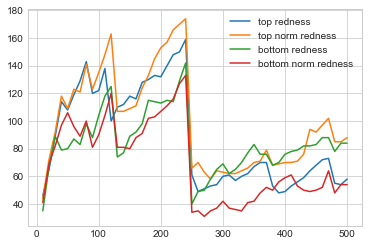

In [28]:
# Import plotting stuff:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Axis:
fig = plt.figure()
ax = plt.axes()

# Data:
line1 = ax.plot([row[0] for row in nsig], [row[1] for row in nsig], label='top redness')
line2 = ax.plot([row[0] for row in nsig], [row[2] for row in nsig], label='top norm redness')
line3 = ax.plot([row[0] for row in nsig], [row[3] for row in nsig], label='bottom redness')
line4 = ax.plot([row[0] for row in nsig], [row[4] for row in nsig], label='bottom norm redness')
ax.legend();